# [FootShirt.com](https://www.footshirt.com)
![alt text](https://www.footshirt.com/assets/logo/footshirtlogo-small.png "FootShirt.com")

[FootShirt.com](https://www.footshirt.com) is the site for football (soccer) fans that enjoy collecting jerseys and/or are passionate by the history 
and values communicated by soccer shirts. 

Managing your jerseys collection can not be easier. Easily add your jerseys to your digital closet. Browse through the available jerseys or add your own. 
Add the jerseys you plan to buy or receive as a gift to your Wishlist that you can share with friends and family. 

Read our blog that features articles about soccer shirts. Do you think you know everything about soccer jerseys? Try our quizzes and compete with other 
fans around the world to be on the top of the leaderboard.

### Introduction
This notebook studies football shirts colors. Each jersey is assigned one (and only one) dominant color (rgb triplet). A future version 
will handle several dominant colors to take into account shirts such as juventus Turin jerseys where both black and white are dominant colors.

### Dataset Description

| Field                 | Description   | Example/Value
| --------------------- | --- | ---
| **id**                | jersey unique id                                    | 1, 2, 3
| **team_id**           | team unique id                                      | 1, 2, 3
| **teamname**          | team name                                           | Boca Juniors
| **teamtype**          | team type                                           | Club, National   
| **teamcountry**       | team country                                        | Argentina    
| **image_caption**     | concatenation of team name, season, and jersey type | Boca Juniors 2018-2019 Home
| **season**            | season                                              | 2018-2019
| **homeawaythird**     | jersey type                                         | Home, Away, Third, Goalkeeper  
| **image_color**       | jersey dominant color                               | rgb(50,72,81)
| **image_r**           | jersey dominant color red component                 | Number between 0 and 255, e.g. 50  
| **image_g**           | jersey dominant color green component               | Number between 0 and 255, e.g. 72
| **image_b**           | jersey dominant color blue component                | Number between 0 and 255, e.g. 81
| **image_cluster**     | ?                                                   | ?
| **image_content_url** | ?                                                   | ?
| **image_id**          | ?                                                   | 1
| **brand_id**          | kit supplier unique id                              | 1, 2, 3
| **brandname**         | kit supplier                                        | Adidas, Nike, Puma
| **urlname**           | ?                                                   |        


In [63]:
%matplotlib inline



### Import

In [75]:
import struct
from PIL import Image
import numpy as np
import webcolors as wb
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()  # for plot styling
import scipy
from scipy.cluster.vq import vq, kmeans, whiten
from  scipy.spatial.distance  import cdist
from math import sqrt
import requests
from matplotlib import rcParams
# from matplotlib import style
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import HTML, display

import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

rcParams['axes.titlepad'] = 20
rcParams['axes.labelpad'] = 5
rcParams["figure.facecolor"] = 'w'
# style.use('ggplot')


### Retrieve Jersey Information from FootShirt.com (API)


In [65]:
JERSEY_API_URL_UAT = 'http://localhost:3000/api/jerseys'
JERSEY_API_URL = 'https://footshirt.herokuapp.com/api/jerseys'
JERSEYS_COLORS_FILENAME = "jerseys_colors.csv"
r = requests.get(JERSEY_API_URL_UAT)
if r.status_code == 200:
    df_jerseys = pd.DataFrame(r.json())
    # delete the output file if it exists
    if os.path.exists(JERSEYS_COLORS_FILENAME):
        os.remove(JERSEYS_COLORS_FILENAME)
    
    df_jerseys.to_csv(JERSEYS_COLORS_FILENAME, sep=';', index=False)
    print(len(df_jerseys), 'jerseys found')    

### Retrieve Jersey Information from csv file (Provide csv file)


2541 jerseys found


Retrieve Colors

# Chart Colors

In [66]:
print ('temp')

temp


In [67]:
print ('Break down, Home vs Away vs Thrd (Goal Keeper)')


Break down, Home vs Away vs Thrd (Goal Keeper)


Break down, Home vs Away vs Third (Goal Keeper)



Break Down by year/period


Break Down by Country


Focus on a club?


# Football Shirts Dominant Colors
The chart below show dominant colors for the entire FootShirt.com database, i.e about 3,000 jerseys. It's worth noticing 
that very few teams play in green

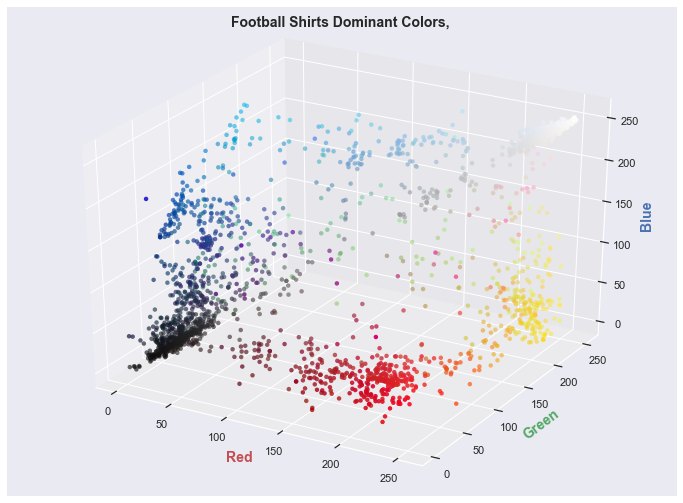

In [81]:
df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['image_r', 'image_g', 'image_b'])
X = df_colors[['image_r', 'image_g', 'image_b']].values
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=20, edgecolors='none')
ax.set_xlabel('Red', fontsize=14, fontweight='bold', color='r')
ax.set_ylabel('Green',  fontsize=14, fontweight='bold', color='g')
ax.set_zlabel('Blue',  fontsize=14, fontweight='bold', color='b', rotation=90)
ax.set_title( 'Football Shirts Dominant Colors, ', fontsize=14, fontweight='bold')
plt.show()


# Football Shirts Dominant Colors for the 2018 Fifa World Cup Russia
The chart below show dominant colors for the entire FootShirt.com database, i.e about 3,000 jerseys. Many teams are playing in Red or White.

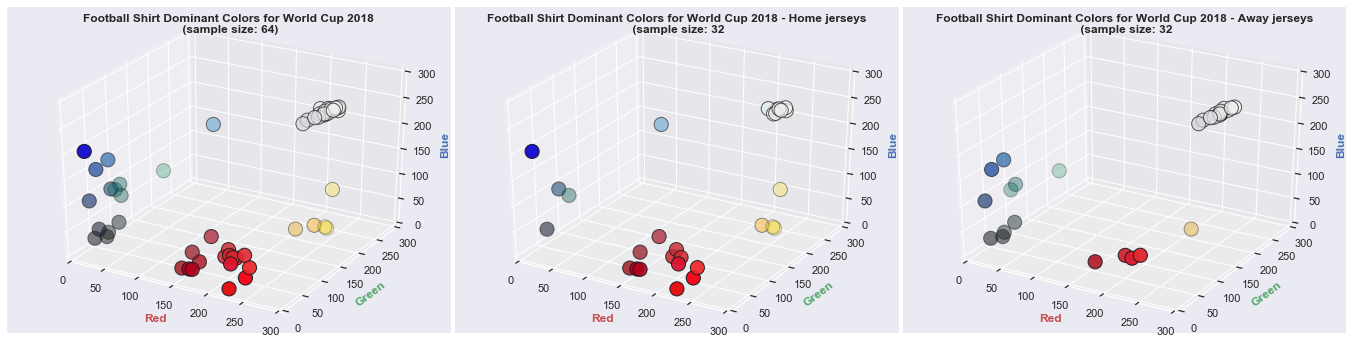

In [100]:
# Define the scope
teamnames = ['Argentina', 'Australia', 'Belgium', 'Brazil', 'Colombia', 'Costa Rica', 'Croatia', 'Denmark', 'Egypt', 
             'England', 'France', 'Germany', 'Iceland', 'Iran', 'Japan', 'South Korea', 'Mexico', 'Morocco', 
             'Nigeria', 'Panama', 'Peru', 'Poland', 'Portugal', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 
             'Spain', 'Sweden', 'Switzerland', 'Tunisia', 'Uruguay']
season = '2018'
jersey_types = ['Home', 'Away']
# Load Dataset
df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['teamname', 'season', 'homeawaythird', 'image_r', 'image_g', 'image_b','teamname'])

fig = plt.figure(figsize=(24,6))
fig.subplots_adjust(hspace=0.1, wspace=0.01)

df_colors_type = df_colors [(df_colors['teamname'].isin(teamnames)) & (df_colors['homeawaythird'].isin(jersey_types)) &
    (df_colors['season'] == '2018')]
X = df_colors_type[['image_r', 'image_g', 'image_b']].values
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=200, linewidths=1, edgecolors='k')
ax.set_xlim3d(0,300)
ax.set_ylim3d(0,300)
ax.set_zlim3d(0,300)
ax.set_xlabel('Red', fontsize=12, fontweight='bold', color='r')
ax.set_ylabel('Green',  fontsize=12, fontweight='bold', color='g')
ax.set_zlabel('Blue',  fontsize=12, fontweight='bold', color='b', rotation=90)
title = 'Football Shirt Dominant Colors for World Cup 2018\n (sample size: {})'.format(len(df_colors_type))
ax.set_title( title, fontsize=12, fontweight='bold',  pad = 0)
 
i = 1
for jersey_type in jersey_types:
    df_colors_type = df_colors [(df_colors['teamname'].isin(teamnames)) & (df_colors['homeawaythird'] == jersey_type) &
    (df_colors['season'] == '2018')]
    X = df_colors_type[['image_r', 'image_g', 'image_b']].values
    ax = fig.add_subplot(1, len (jersey_types)+1, i + 1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=200, linewidths=1, edgecolors='k')
    ax.set_xlim3d(0,300)
    ax.set_ylim3d(0,300)
    ax.set_zlim3d(0,300)
    ax.set_xlabel('Red', fontsize=12, fontweight='bold', color='r')
    ax.set_ylabel('Green',  fontsize=12, fontweight='bold', color='g')
    ax.set_zlabel('Blue',  fontsize=12, fontweight='bold', color='b', rotation=90)
    title = 'Football Shirt Dominant Colors for World Cup 2018 - {} jerseys\n (sample size: {}'.format(jersey_type,len(df_colors_type))
    ax.set_title(title , fontsize=12, fontweight='bold', pad = 0)
    i += 1




# Liverpool

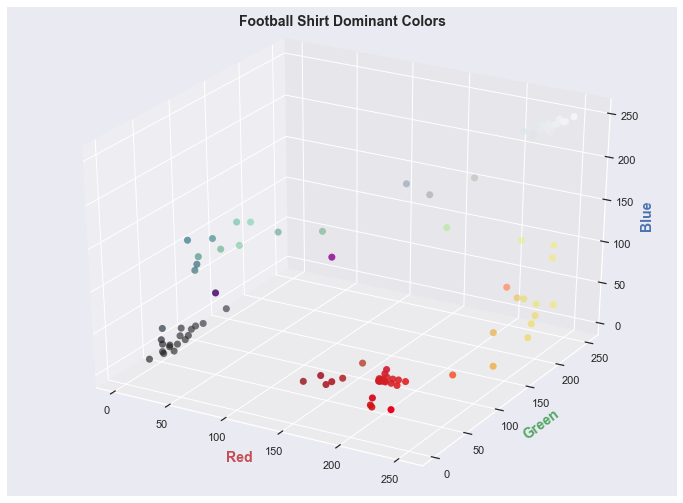

In [69]:
df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['image_r', 'image_g', 'image_b','teamname'])
df_colors = df_colors [df_colors['teamname']=='Liverpool']
X = df_colors[['image_r', 'image_g', 'image_b']].values
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=50, edgecolors='none')


ax.set_xlabel('Red', fontsize=14, fontweight='bold', color='r')
ax.set_ylabel('Green',  fontsize=14, fontweight='bold', color='g')
ax.set_zlabel('Blue',  fontsize=14, fontweight='bold', color='b', rotation=90)
ax.set_title( 'Football Shirt Dominant Colors', fontsize=14, fontweight='bold', pad=20)
plt.show()



## Liverpool Home/Away/Third Jersey

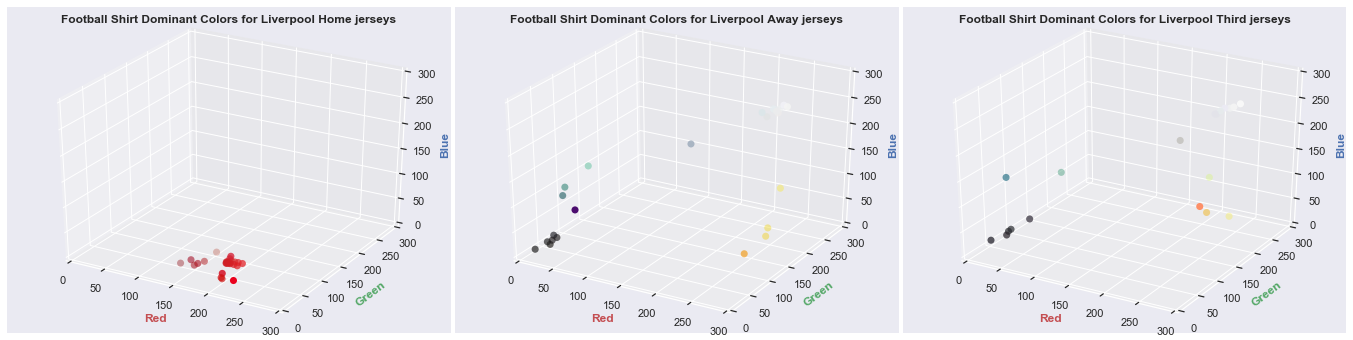

In [70]:
teamname = 'Liverpool'
# Define the Jersey Type that we will take into account
jersey_types = ['Home', 'Away', 'Third']
# Load Dataset
df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['image_r', 'image_g', 'image_b','teamname', 'homeawaythird'])

fig = plt.figure(figsize=(24,6))
fig.subplots_adjust(hspace=0.1, wspace=0.01)
  
i = 1
for jersey_type in jersey_types:
    df_colors_type = df_colors [(df_colors['teamname']== teamname) & (df_colors['homeawaythird'] == jersey_type)]
    X = df_colors_type[['image_r', 'image_g', 'image_b']].values
    ax = fig.add_subplot(1, len (jersey_types), i, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=50, edgecolors='none')
    ax.set_xlim3d(0,300)
    ax.set_ylim3d(0,300)
    ax.set_zlim3d(0,300)
    ax.set_xlabel('Red', fontsize=12, fontweight='bold', color='r')
    ax.set_ylabel('Green',  fontsize=12, fontweight='bold', color='g')
    ax.set_zlabel('Blue',  fontsize=12, fontweight='bold', color='b', rotation=90)
    ax.set_title( 'Football Shirt Dominant Colors for '+ teamname + " "+  jersey_type + ' jerseys', fontsize=12, fontweight='bold', pad = 10)
    i += 1



## Comparison between two teams

Text(0.5, 0.92, 'Football Shirt Dominant Colors comparison between Manchester United and Arsenal Home jerseys')

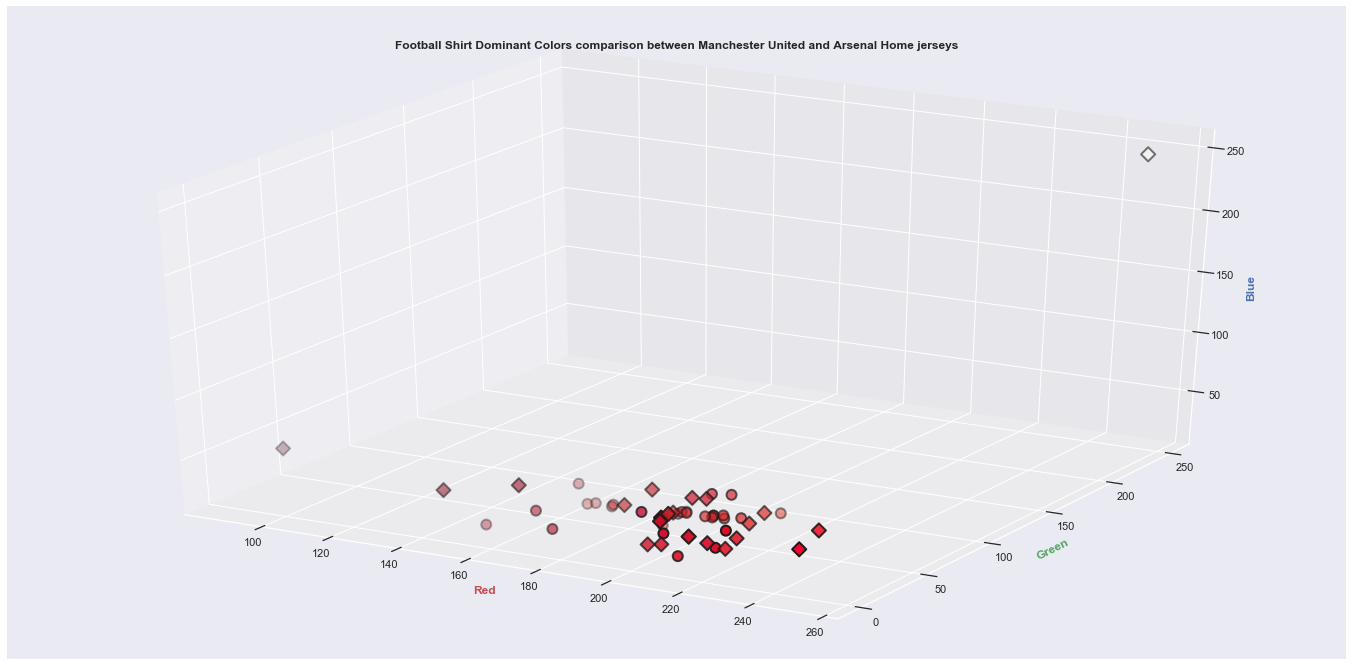

In [73]:
teamnames = ['Manchester United', 'Arsenal']
# Define the Jersey Type that we will take into account
jersey_type = 'Home'

# Load Dataset
df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['image_r', 'image_g', 'image_b','teamname', 'homeawaythird'])

fig = plt.figure(figsize=(24,12))
  
df_colors_team1 = df_colors [(df_colors['teamname']== teamnames[0]) & (df_colors['homeawaythird'] == jersey_type)]
X = df_colors_team1[['image_r', 'image_g', 'image_b']].values
df_colors_team2 = df_colors [(df_colors['teamname']== teamnames[1]) & (df_colors['homeawaythird'] == jersey_type)]
Y = df_colors_team2[['image_r', 'image_g', 'image_b']].values
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X/255.0, s=100, marker ='o', linewidths=2, edgecolors='k')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=Y/255.0, s=100, marker ='D', linewidths=2, edgecolors='k')
ax.set_xlabel('Red', fontsize=12, fontweight='bold', color='r')
ax.set_ylabel('Green',  fontsize=12, fontweight='bold', color='g')
ax.set_zlabel('Blue',  fontsize=12, fontweight='bold', color='b', rotation=90)
ax.set_title( 'Football Shirt Dominant Colors comparison between '+ teamnames[0] + ' and ' + teamnames[1] + ' ' +  jersey_type + ' jerseys', fontsize=12, fontweight='bold', pad = 10)
    


Color Picker
https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [74]:
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)


ColorPicker(value='blue', description='Pick a color')

Country: careful because some teams have more jersey...
Season: perhaps
Country/Season/Type?
2000-2005, 2006-2010, 2011-2015, 2016-2019


In [80]:
data = [[1,2,3],
        [4,5,6],
        [7,8,9],
        ]

df_colors = pd.read_csv(JERSEYS_COLORS_FILENAME, sep=';',usecols  =['teamname','image_r', 'image_g', 'image_b','image_caption'])
df_colors = df_colors [df_colors['teamname']=='Liverpool']
print (df_colors.head(5))
# X = df_colors[['image_r', 'image_g', 'image_b']].values

display(HTML(
   '<table><tr><th>Jersey</th><th>Jersey Picture</th><th>Color</th></tr><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in df_colors)
       )
))

df_colors.to_html

     image_b                   image_caption  image_g  image_r   teamname
340     25.0        Liverpool 2018-2019 Home     19.0    148.0  Liverpool
341    111.0        Liverpool 2018-2019 Away     13.0     76.0  Liverpool
342    190.0       Liverpool 2018-2019 Third    194.0    196.0  Liverpool
343    103.0  Liverpool 2018-2019 Goalkeeper    237.0    244.0  Liverpool
344     39.0        Liverpool 2017-2018 Home     16.0    165.0  Liverpool


<bound method DataFrame.to_html of      image_b                          image_caption  image_g  image_r  \
340     25.0               Liverpool 2018-2019 Home     19.0    148.0   
341    111.0               Liverpool 2018-2019 Away     13.0     76.0   
342    190.0              Liverpool 2018-2019 Third    194.0    196.0   
343    103.0         Liverpool 2018-2019 Goalkeeper    237.0    244.0   
344     39.0               Liverpool 2017-2018 Home     16.0    165.0   
345    240.0               Liverpool 2017-2018 Away    240.0    237.0   
346    103.0              Liverpool 2017-2018 Third    143.0    253.0   
347     91.0   Liverpool 2017-2018 Goalkeeper Green    181.0      3.0   
348     28.0   Liverpool 2017-2018 Goalkeeper Black     24.0     26.0   
349     41.0               Liverpool 2016-2017 Home     26.0    209.0   
350     21.0               Liverpool 2016-2017 Away     25.0     29.0   
351     94.0              Liverpool 2016-2017 Third    248.0    210.0   
352    103.0    